In [1]:
import torch
import gc

import numpy as np
import matplotlib.pyplot as plt

from transformers import SamProcessor, SamModel, pipeline
from PIL import Image, ImageDraw

/home/eranario/miniconda3/envs/lightning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-23 13:13:50.831306: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-23 13:13:50.861216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 13:13:50.883590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23

In [2]:
def load_yolo_annotations(yolo_file):
    with open(yolo_file, 'r') as file:
        annotations = file.readlines()
    bboxes = []
    for annotation in annotations:
        parts = annotation.strip().split()
        x_center, y_center, width, height = map(float, parts[1:])
        bboxes.append((x_center, y_center, width, height))
    return bboxes

def draw_bboxes(image, bboxes):
    draw = ImageDraw.Draw(image)
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        left = (x_center - width / 2) * image.width
        right = (x_center + width / 2) * image.width
        top = (y_center - height / 2) * image.height
        bottom = (y_center + height / 2) * image.height
        draw.rectangle([left, top, right, bottom], outline="red", width=2)
    return image

def create_semantic_mask(mask, bboxes):
    # Create a blank semantic mask initialized with background (0)
    semantic_mask = np.zeros(mask.shape, dtype=np.uint8)

    # Apply the segmentation mask to the areas within the bounding boxes
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        left = int((x_center - width / 2) * mask.shape[1])
        right = int((x_center + width / 2) * mask.shape[1])
        top = int((y_center - height / 2) * mask.shape[0])
        bottom = int((y_center + height / 2) * mask.shape[0])

        # Assign 1 to the object class within the bounding box
        semantic_mask[top:bottom, left:right] = np.where(mask[top:bottom, left:right] == 1, 1, semantic_mask[top:bottom, left:right])

    return semantic_mask

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for mask in masks:
        show_mask(mask, ax=ax, random_color=True)
    plt.axis("off")
    plt.show()
    del masks
    gc.collect()

def main(image_path, yolo_file):
    image = Image.open(image_path).convert("RGB")
    bboxes = load_yolo_annotations(yolo_file)
    image_with_bboxes = draw_bboxes(image.copy(), bboxes)
    
    # Load SAM model and processor
    device = "cuda" if torch.cuda.is_available() else "cpu"
    processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")
    model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)

    input_points = []
    input_labels = []
    for bbox in bboxes:
        x_center, y_center, width, height = bbox
        x = x_center * image.width
        y = y_center * image.height
        input_points.append([x, y])
        input_labels.append(1)

    inputs = processor(image, input_points=[input_points], input_labels=[input_labels], return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    masks = processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu()
    )[0]

    masks = masks.squeeze().numpy()
    if masks.ndim == 3 and masks.shape[0] == 1:
        masks = masks[0]
    elif masks.ndim == 3 and masks.shape[0] == 3:
        masks = np.mean(masks, axis=0)

    # Create the semantic mask for the object (1 for objects)
    semantic_mask = create_semantic_mask(masks, bboxes)

    # Use automatic mask generation for background
    generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)
    outputs_bg = generator(image, points_per_batch=64)
    background_masks = outputs_bg["masks"]
    return background_masks, semantic_mask

    # # Combine object and background masks into a final mask
    # final_semantic_mask = semantic_mask.copy()
    # for bg_mask in background_masks:
    #     final_semantic_mask = np.where(bg_mask > 0, 2, final_semantic_mask)  # 2 for background

    # fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    # axes[0].imshow(image_with_bboxes)
    # axes[0].set_title("Original Image with BBoxes")
    
    # axes[1].imshow(semantic_mask, cmap='tab10')
    # axes[1].set_title("Object Semantic Segmentation Mask")
    
    # axes[2].imshow(background_masks, cmap='tab10')
    # axes[2].set_title("Final Semantic Segmentation Mask with Background")
    # plt.show()



In [3]:
image_path = "/group/jmearlesgrp/data/yolo_grl_data/BordenNight/Synthetic/images/00000.jpg"
# image_path = "/group/jmearlesgrp/data/yolo_grl_data/GEMINI_Flowers/Synthetic/images/camA_cowpea_018_000_3710807_RGB.jpeg"
yolo_file = "/group/jmearlesgrp/data/yolo_grl_data/BordenNight/Synthetic/labels/00000.txt"
# yolo_file = "/group/jmearlesgrp/data/yolo_grl_data/GEMINI_Flowers/Synthetic/labels/camA_cowpea_018_000_3710807_RGB.txt"
background_masks, semantic_mask = main(image_path, yolo_file)

In [4]:
def get_largest_masks(masks, num_masks=3):
    # Calculate the area of each mask
    mask_areas = [(i, np.sum(mask > 0)) for i, mask in enumerate(masks)]
    
    # Sort masks by area in descending order
    mask_areas.sort(key=lambda x: x[1], reverse=True)
    
    # Get the indices of the three largest masks
    largest_mask_indices = [idx for idx, area in mask_areas[:num_masks]]
    
    # Keep only the largest masks
    largest_masks = [masks[idx] for idx in largest_mask_indices]
    
    return largest_masks, largest_mask_indices

largest_masks, largest_mask_indices = get_largest_masks(background_masks, num_masks=3)

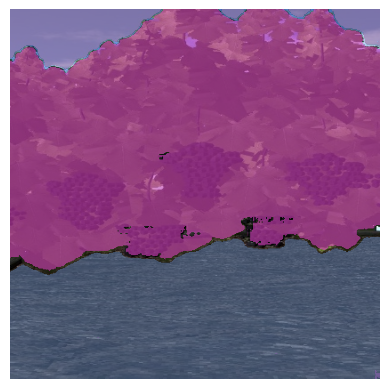

In [5]:
show_masks_on_image(Image.open(image_path).convert("RGB"), largest_masks)

In [6]:
largest_masks.extend([semantic_mask])

In [7]:
len(largest_masks)

4

In [14]:
def combine_masks(masks):
    
    all_masks = np.zeros_like(masks[0])
    output_masks = np.zeros((3, 416, 416), dtype=np.uint8)
    
    # Combine all masks 
    for i, mask in enumerate(masks):
        mask[mask == True] = i + 1
        all_masks = np.where(mask, i + 1, all_masks)
        
    # Assign colors
    colors = {
        1: [255, 0, 0], # red
        2: [0, 255, 0], # green
        3: [0, 0, 255], # blue
        4: [255, 255, 0], # yellow
    }
    for value, color in colors.items():
        locs = all_masks == value
        for channel, intensity in enumerate(color):
            output_masks[channel][locs] = intensity
            
    return output_masks

output_masks = combine_masks(largest_masks)

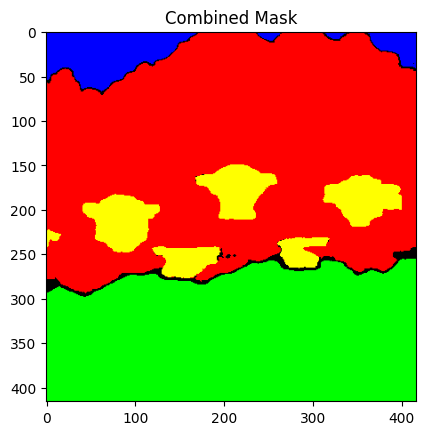

In [15]:
plt.imshow(output_masks.transpose(1, 2, 0))
plt.title("Combined Mask")
plt.show()

In [12]:
output_masks.dtype

dtype('uint8')